# Deep Learning - Project 2

## Initial idea

The ultimate goal of the project is to classify defects on the timeseries into 5 classes and localize the defects. The RNN shall be used. As it follows from the project goal, provided algorithm consists of 2 logical parts:

1. Creating an RNN-based multilabel binary classifier for detecting the defects of certain types in time series data
2. Using a gradient-based explainability approach to localize the x-axis intervals that influenced classifier's decision the most (expectedly, the defected areas)

Reletively small models are used for a binary classifier as the problem statement itself is not overcomplicated. The main problem is that models can't be trained using masks (data on the defected intervals) so the explainability part is prone to erros because the models may learn to rely on irrelevant paterns in the data.

## Setup

In [1]:
runtime_environment = 'kaggle'  # local, kaggle
load_models = True

In [2]:
if runtime_environment == 'kaggle':
    !rm -rf time-series-defect-detection
    !git clone https://github.com/vasia-korz/time-series-defect-detection
    !cd time-series-defect-detection
    !ln -sf time-series-defect-detection/classes classes
        
    import tensorflow as tf

    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    print("Using GPU: ", tf.test.is_gpu_available())

    # List available physical devices
    tf.config.list_physical_devices('GPU')

    # Set memory growth for the GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Allow TensorFlow to use only as much GPU memory as needed
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("Memory growth enabled for GPUs")
        except RuntimeError as e:
            print(e)

Cloning into 'time-series-defect-detection'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 70 (delta 35), reused 55 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (70/70), 1.37 MiB | 19.00 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Num GPUs Available:  1
Using GPU:  True
Memory growth enabled for GPUs


In [3]:
%load_ext autoreload
%autoreload 2

from classes.analyzer import Analyzer
from classes.data_generator import DataGenerator
from classes.data_preprocessor import DataPreprocessor
from classes.explainer import Explainer
from classes.model import Model

import pandas as pd

import warnings
import absl.logging

warnings.filterwarnings("ignore")
absl.logging.set_verbosity(absl.logging.ERROR)

## Generation & spliting of data

Data generation process is copied from the notebook provided by the professor, however, it is extended to generate the masks too. The masks indicate which x-axis intervals are truly effected by the corresponding defects. Masks provide ground thruth for evaluation purposes (**masks are not used for training**).

Later the data is splited into train, test, and validation sets (80% / 10% / 10%). To handle sequences of varying lengths the data is preprocessed so that all `x`s match the longest sequence in the dataset. Padding is either applied from the beginning or from the end of the time series. The padding consists of large negative numbers (-999), and is ignored during model training (because of a `Masking` layer in the RNN architecture).

[ True  True False False False]


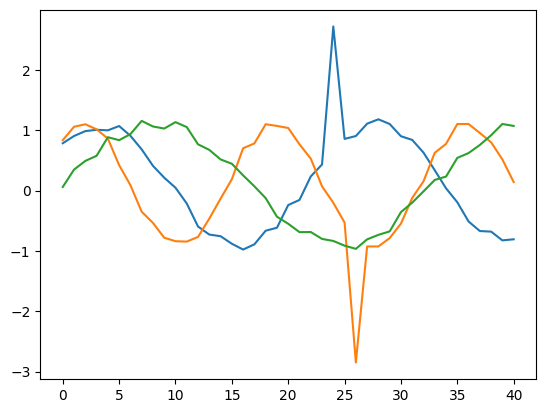

[False False  True False False]


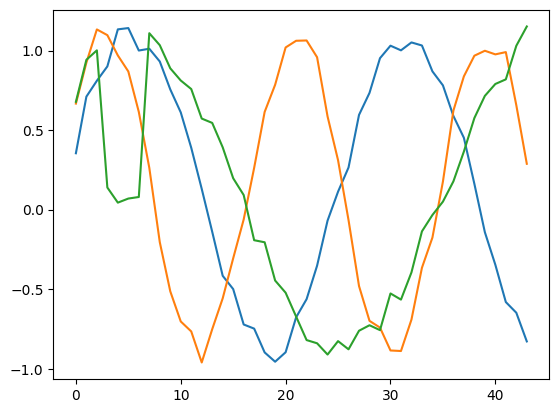

[False False False  True False]


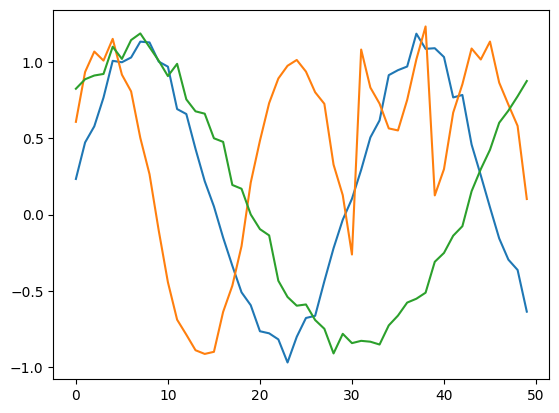

X shape of the 1st data element: (41, 3)
y shape of the 1st data element: (5,)

X shape: (50000, 59, 3)
y shape: (50000, 5)
Train / Test / Val: 40000 / 5000 / 5000


In [4]:
data_gen = DataGenerator()
data_gen.visualize_data()
xl, yl, masks = data_gen.get_data()

print(f"X shape of the 1st data element: {xl[0].shape}\ny shape of the 1st data element: {yl[0].shape}\n")

# Data padded from the right
preprocessor = DataPreprocessor(debug=True)
x_train, y_train, masks_train, x_test, y_test, masks_test, x_val, y_val, masks_val = preprocessor.get_data(xl, yl, masks)

# Data padded from the left
preprocessor_pre = DataPreprocessor(padding='pre')
x_train_pre, y_train_pre, masks_train_pre, x_test_pre, y_test_pre, masks_test_pre, x_val_pre, y_val_pre, masks_val_pre = preprocessor_pre.get_data(xl, yl, masks)

## Sample algorithm run

### Model training / loading

Each tested model has a single RNN layer, namely, `LSTM`, `GRU`, or `Bidirectional(LSTM)`. The `input_shape` for the models is set to `(seq_len, n_features)` where `seq_len` is the length of the padded sequence and `n_features = 3` corresponding to the number of time series features in each input (`x`) (i.e. each data element has a shape of `(seq_len, 3)`).

Below the two baseline models are trained / loaded. Both models use  an LSTM layer with 128 neurons and are trained for 50 epochs. The difference between the models lies in the padding type ('post' and 'pre').

In [5]:
path_post = "models/post.h5" 
path_pre = "models/pre.h5"

if runtime_environment == 'kaggle':
    path_post = "/kaggle/input/post/tensorflow2/default/1/post.h5"
    path_pre = "/kaggle/input/pre/tensorflow2/default/1/pre.h5"

model_post = Model(load=load_models, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, path=path_post)
model_pre = Model(load=load_models, x_train=x_train_pre, y_train=y_train_pre, x_val=x_val_pre, y_val=y_val_pre, path=path_pre, padding="pre")

### Evaluation

Both models exhibit extremely high accuracy. At this point it is worth mentioning that post-padding is better supported by CUDA and training on pre-padded data takes much longer time. Moreover, there are no apperent differences in how the models localize the defected regions (it was tested, however, not included into the report for brevity). Finally, it is supported from the standpoint that `Masking` layer is used, so padding is ignored during the training. Therefore, the algorithm will proceed with the model trained on the post-padded data exclusively.

**Note:** One notable inconvenience is that when using pre-padded data, the `use_cudnn=False` flag is not preserved after saving and loading the model. As a result, the pre-padded model must be recreated manually (with default parameters) before loading its weights. This further supports the decision to focus on post-padded models in the subsequent steps.

In [6]:
classifier_accuracy = model_post.evaluate(x_test, y_test, compute_preds=True)
print(f"Classifier accuracy for the model with post-padded data: {classifier_accuracy}\n")

from tensorflow.keras.layers import LSTM, Masking, Dense
from tensorflow.keras.models import Sequential

model_pre_by_hand = Sequential()
model_pre_by_hand.add(Masking(mask_value=-999, input_shape=(59, 3)))
model_pre_by_hand.add(LSTM(128, return_sequences=False, use_cudnn=False))
model_pre_by_hand.add(Dense(5, activation='sigmoid'))
model_pre_by_hand.compile(loss='binary_crossentropy', metrics=['accuracy'])
model_pre_by_hand.load_weights(path_pre)
model_pre.model = model_pre_by_hand

classifier_accuracy_pre = model_pre.evaluate(x_test_pre, y_test_pre, compute_preds=True)
print(f"Classifier accuracy for the model with pre-padded data: {classifier_accuracy_pre}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Classifier accuracy for the model with post-padded data: 0.9932

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Classifier accuracy for the model with pre-padded data: 0.9922


### Detecting regions with defects

The process of detecting defects involves analyzing how different points of the time series contribute to the model's predictions. Thes is achieved using gradient-based explainability techniques.

* **The first plot:** Shows a single data instance with its features spread accross three subplots.
* **The second plot:** Shows importance of individual points on each feature. Using gradient information, these plots indicate which regions contribute to the classifier's detection of a particular defect the most.
* **The third plot:** Focuses on the feature that was classified as the most significant (feature with the highest spike). It highlights the detected most important region with red color (the spike extended by values in its neighborhood that are heigher than the feature's mean).

Predicted classes: [0 1 1 0 0]
Expected classes: [0 1 1 0 0] 

Deffect class 1


<Figure size 1500x400 with 0 Axes>

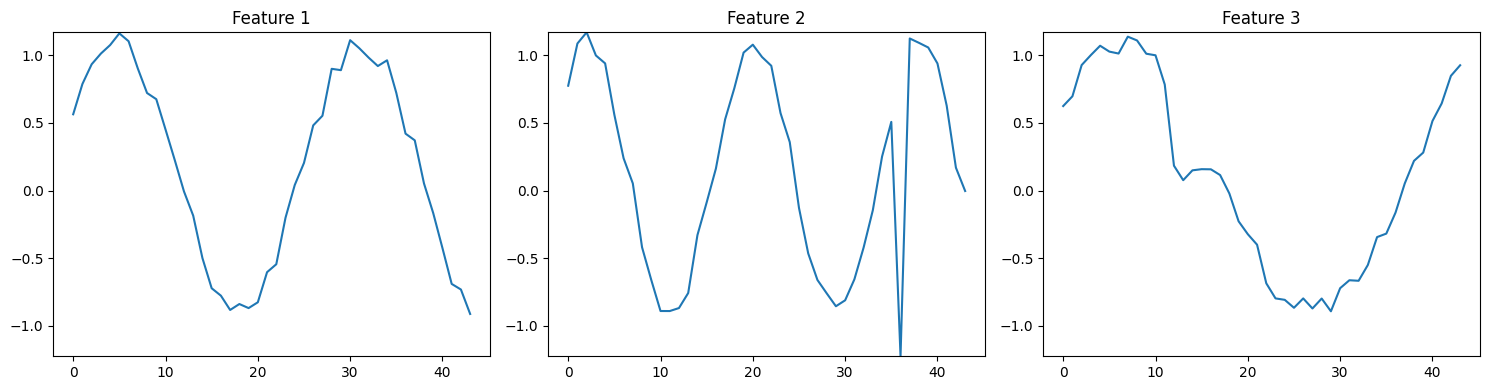

<Figure size 1500x400 with 0 Axes>

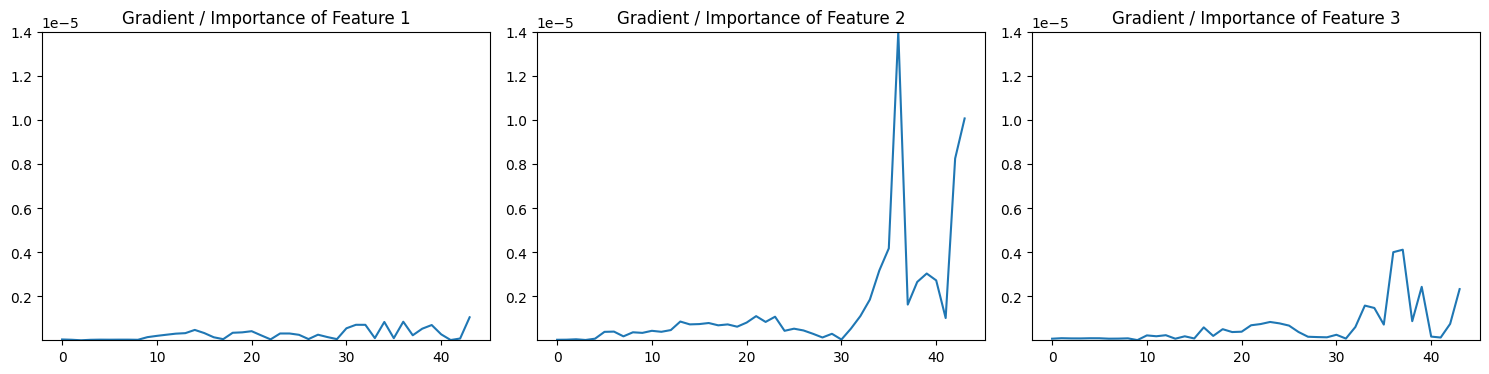

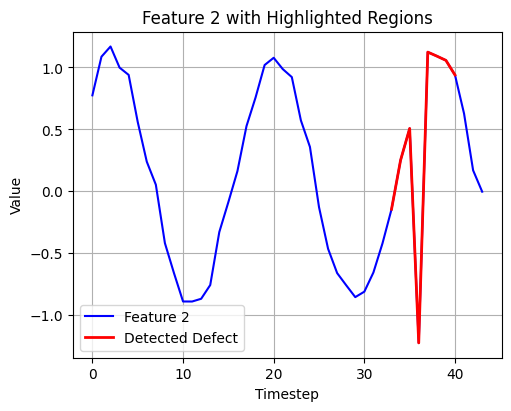

Deffect class 2


<Figure size 1500x400 with 0 Axes>

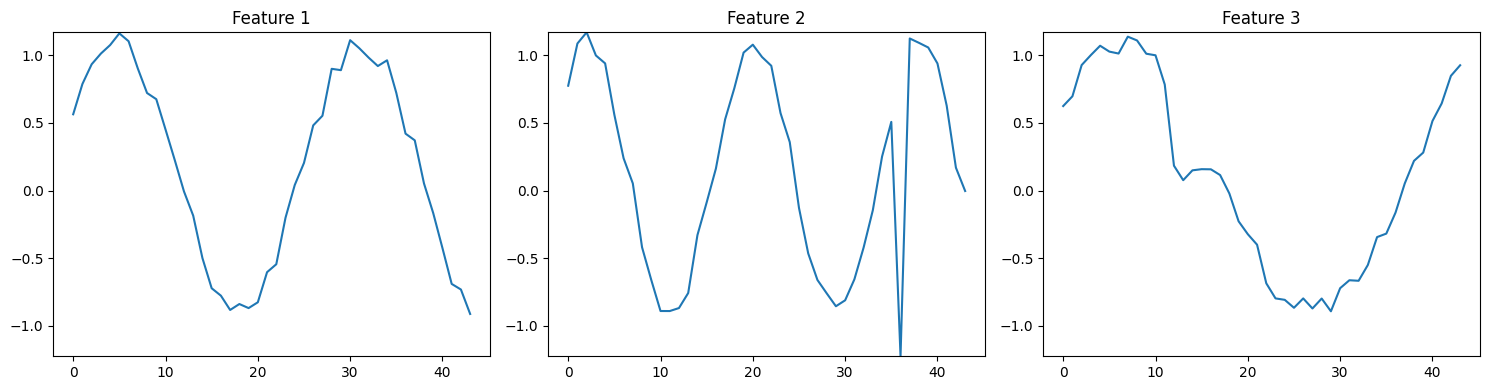

<Figure size 1500x400 with 0 Axes>

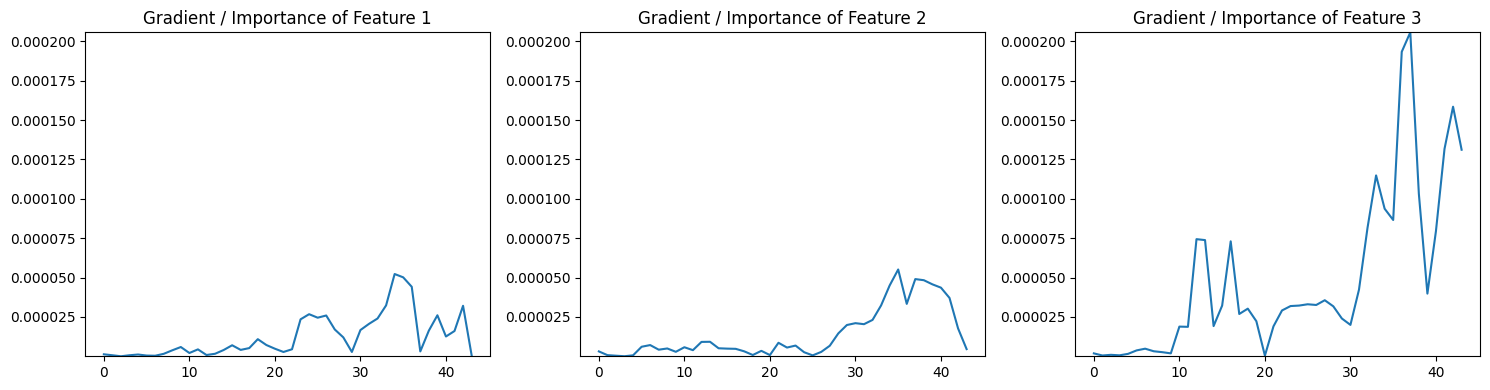

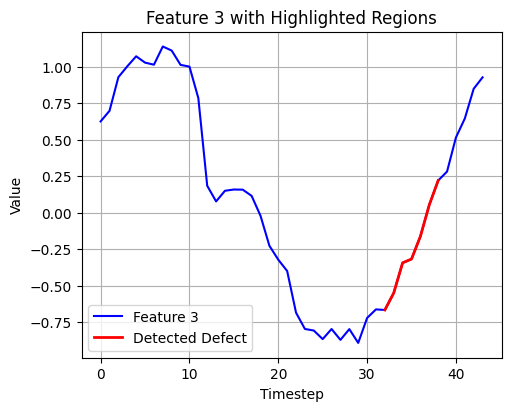

In [7]:
explainer = Explainer(model_post, x_test, y_test, masks_test)
_ = explainer.gen_single(50, integrated_grads=False)

Two defects were identified in the example above. The defect of the first class was identified correctly (we can see that it effectively covers the spike). Nevertheless, the IOU for such detection wouldn't be equal to 1 because instead of a single defect point a series of neighboring points were detected as defected ones to. The second defect wasn't identified correctly, we can see on the gradient plot that an unrelated area was identified as important for the decision, however, the region that really mattered had a lover spike on the gradient plot.

### Final evaluation

Finally, the set of 200 data instances is processed by the algorithm and is analyzed using 2 metrics (overall and class-wise).

* **Accuracy**: Shows how often the detected defected region overlaps with ground truth defect mask. (e.g. accuracy of 25% would mean that the algorithm identifies one out of four defects). Nevertheless, accuracy alone might be misleading, for instance, if the model returns all the x-axis as defected then the accuracy will be close to 1, however, there will be no localization of the defected regions. To account for that the second metric is also used (IOU).
* **IOU**: Intersection over union considers both high presision and recall. While accuracy rewards overlap with defected region, IOU penalizes the inclusion of irrelevant areas. A model returning the entire x-axis as defected would yield a high accuracy but an extremely low IOU.

Both Accuracy and IOU are used to analyze effectiveness of models in this report. 

It is also worth noting that IOU is always smaller or equal to the Accuracy.

In [8]:
explainer.gen_explanations(200)

Generating Explanations: 100%|██████████| 200/200 [00:18<00:00, 10.57it/s]


In [9]:
analyzer = Analyzer(explainer, x_test, y_test, masks_test)

accuracy = analyzer.accuracy()
iou = analyzer.iou()
class_based_accuracy = analyzer.class_based_accuracy()
class_based_iou = analyzer.class_based_iou()

pd.DataFrame(
    data=[["Accuracy", *class_based_accuracy, accuracy], ["IOU", *class_based_iou, iou]],
    columns=["Metric", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Overall"]
)

,Metric,Class 1,Class 2,Class 3,Class 4,Class 5,Overall
0,Accuracy,0.603774,0.586957,0.232143,0.039216,0.06000,0.261438
1,IOU,0.137017,0.183877,0.126892,0.012418,0.03125,0.097742


## Architecture selection

The baseline model performed rather purely, thus 18 sample models will be considered and evaluated to select the best architecture. The following parameters will be changing:

* **Layer type**: `LSTM`, `GRU`, `Bidirectional(LSTM)`
* **Number of neurons in the RNN layer**: 64, 128
* **Number of epochs for training**: 10, 20, 50

In [10]:
save_path = 'models/'
open_path = 'models/'

if runtime_environment == 'kaggle':
    save_path = ''

layer_types = ['lstm', 'gru', 'bi_lstm']
layer_sizes = [64, 128]
epochs = [10, 20, 50]

model_names = []

for layer_type in layer_types:
    for layer_size in layer_sizes:
        for epoch in epochs:
            model_name = f"{layer_type}_{layer_size}_{epoch}.h5"
            model_names.append(model_name)

            if load_models:
                continue
        
            model = Model(layer_type=layer_type, 
                          layer_size=layer_size, 
                          epochs=epoch, 
                          x_train=x_train, 
                          y_train=y_train,
                          x_val=x_val,
                          y_val=y_val
                        )
            model.save(save_path + model_name)

In [11]:
metrics = []

for model_name in model_names:
    if runtime_environment == 'local':
        model = Model(load=True, path=f"models/{model_name}")
    else:
        model = Model(load=True, path=f"/kaggle/input/{model_name.replace('.h5', '')}/tensorflow2/default/1/{model_name}")

    classifier_accuracy = model.evaluate(x_test, y_test, compute_preds=True)

    explainer = Explainer(model, x_test, y_test, masks_test)
    explainer.gen_explanations(200)
    
    analyzer = Analyzer(explainer, x_test, y_test, masks_test)
    accuracy = analyzer.accuracy()
    class_based_accuracy = analyzer.class_based_accuracy()
    iou = analyzer.iou()
    class_based_iou = analyzer.class_based_iou()

    metrics.append([model_name, classifier_accuracy, accuracy, *class_based_accuracy, iou, *class_based_iou])

df = pd.DataFrame(data=metrics, columns=[
    "Model", 
    "Classifier accuracy", 
    "Accuracy", 
    "Class 1 Acc", 
    "Class 2 Acc", 
    "Class 3 Acc", 
    "Class 4 Acc", 
    "Class 5 Acc", 
    "IOU",
    "Class 1 IOU", 
    "Class 2 IOU", 
    "Class 3 IOU", 
    "Class 4 IOU", 
    "Class 5 IOU", 
])

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Generating Explanations: 100%|██████████| 200/200 [00:18<00:00, 10.76it/s]


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Generating Explanations: 100%|██████████| 200/200 [00:19<00:00, 10.34it/s]


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Generating Explanations: 100%|██████████| 200/200 [00:18<00:00, 10.72it/s]


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Generating Explanations: 100%|██████████| 200/200 [00:19<00:00, 10.29it/s]


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Generating Explanations: 100%|██████████| 200/200 [00:19<00:00, 10.20it/s]


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Generating Explanations: 100%|██████████| 200/200 [00:19<00:00, 10.17it/s]


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Generating Explanations: 100%|██████████| 200/200 [00:18<00:00, 10.96it/s]


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Generating Explanations: 100%|██████████| 200/200 [00:19<00:00, 10.03it/s]


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Generating Explanations: 100%|██████████| 200/200 [00:19<00:00, 10.05it/s]


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Generating Explanations: 100%|██████████| 200/200 [00:19<00:00, 10.41it/s]


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Generating Explanations: 100%|██████████| 200/200 [00:18<00:00, 10.53it/s]


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Generating Explanations: 100%|██████████| 200/200 [00:19<00:00, 10.38it/s]


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Generating Explanations: 100%|██████████| 200/200 [00:24<00:00,  8.05it/s]


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Generating Explanations: 100%|██████████| 200/200 [00:24<00:00,  8.18it/s]


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Generating Explanations: 100%|██████████| 200/200 [00:24<00:00,  8.12it/s]


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Generating Explanations: 100%|██████████| 200/200 [00:28<00:00,  6.97it/s]


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Generating Explanations: 100%|██████████| 200/200 [00:25<00:00,  7.91it/s]


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Generating Explanations: 100%|██████████| 200/200 [00:24<00:00,  8.09it/s]


In [12]:
df

,Model,Classifier accuracy,Accuracy,Class 1 Acc,Class 2 Acc,Class 3 Acc,Class 4 Acc,Class 5 Acc,IOU,Class 1 IOU,Class 2 IOU,Class 3 IOU,Class 4 IOU,Class 5 IOU
0,lstm_64_10.h5,0.7854,0.345277,0.641509,0.673913,0.263158,0.215686,0.150000,0.076595,0.131688,0.028270,0.068289,0.071024,0.077804
1,lstm_64_20.h5,0.9210,0.464286,0.872727,0.934783,0.357143,0.117647,0.260000,0.361587,0.659262,0.709992,0.162438,0.061254,0.243000
2,lstm_64_50.h5,0.9874,0.320261,0.603774,0.695652,0.375000,0.000000,0.130000,0.187707,0.294549,0.352743,0.222638,0.000000,0.074960
3,lstm_128_10.h5,0.9020,0.309148,0.830189,0.782609,0.089552,0.019608,0.110000,0.144852,0.365364,0.252914,0.049919,0.007625,0.078872
4,lstm_128_20.h5,0.9880,0.314935,0.792453,0.391304,0.379310,0.078431,0.110000,0.143439,0.263994,0.138436,0.239548,0.021569,0.033075
5,lstm_128_50.h5,0.9932,0.218954,0.245283,0.434783,0.285714,0.058824,0.150000,0.087525,0.088140,0.138043,0.140691,0.009759,0.060171
6,gru_64_10.h5,0.7626,0.423453,0.849057,1.000000,0.000000,0.019608,0.380000,0.302903,0.565274,0.716063,0.000000,0.004525,0.294335
7,gru_64_20.h5,0.8646,0.444444,0.905660,0.956522,0.339286,0.039216,0.230000,0.272986,0.485430,0.586957,0.137414,0.017157,0.171731
8,gru_64_50.h5,0.9920,0.379085,0.339623,0.782609,0.732143,0.078431,0.170000,0.191379,0.109748,0.278261,0.421488,0.036626,0.098103
9,gru_128_10.h5,0.8770,0.545752,1.000000,1.000000,0.303571,0.254902,0.380000,0.205762,0.279717,0.345316,0.140181,0.064793,0.216220


### Summaries from different architectures

Performance of 18 models was evaluated and the following insides were identified:

1. **Model overcomplication leads to worse results.** Models that were trained for 50 epochs performed rather poorly leading to both lower Accuracy and IOU compared to models trained for 20 epochs. As a matter of fact the models trained for 20 epochs might be considered a sweet spot between overtrained and undertrained models.

2. **10 epochs model had the best accuracy.** The `gru_128_10` got 55% accuracy in detecting the defected regions and also had rather high IOU of of 20.5%. It is worth noting that classifier accuracy is also lower than 90%. Such performance can be explained by the fact that model performs very well on the first two classes of defects (it has ideal accuracy on them), moreover, it is strong in identifying the 5th class of defects, so by learning only a part of paterns it gets decent numbers thanks to them.

3. **Some defect classes are more difficult to identify**. The first two defects are rapid spikes and they can be easily found by the models. The 4th and the 3rd class are the most difficult ones. Class 5 is tricky itself because it influences two features simultaniously. Our model isn't trained to identify defects on two features at a time so the largest accuracy the model could attain on the 5th class is 50% (because the defects on each feature are considered as separate defects, and one out of two defects will be always not found). What was said above leads to a conclusion that the best performing model must be very good at identifying the first two classes of defects.

4. **The best model identified model is `lstm_64_20.h5`**. Its IOU (36%) is only 10 points lower than its defect localization accuracy (46%), indicating strong performance in precise defect localization. The binary classifier accuracy is 92% which is rather low, however, it leads to exceptional metrics comparing to other models.

## In-depth analysis of the most promissing model

In this section `lstm_64_20` will be analyzed based on its results on the whole test set.

In [13]:
model_name = 'lstm_64_20.h5'

if runtime_environment == 'local':
    model = Model(load=True, path=f"models/{model_name}")
else:
    model = Model(load=True, path=f"/kaggle/input/{model_name.replace('.h5', '')}/tensorflow2/default/1/{model_name}")

classifier_accuracy = model.evaluate(x_test, y_test, compute_preds=True)

explainer = Explainer(model, x_test, y_test, masks_test)
explainer.gen_explanations()
    
analyzer = Analyzer(explainer, x_test, y_test, masks_test)
accuracy = analyzer.accuracy()
class_based_accuracy = analyzer.class_based_accuracy()
iou = analyzer.iou()
class_based_iou = analyzer.class_based_iou()

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Generating Explanations: 100%|██████████| 5000/5000 [08:35<00:00,  9.70it/s]


The set of plots below shows examples at which model was predicting the defects of each class and was able (correct predictions) or unable (incorrect predictions) to localize the defect. The true defect is highlighted with green area while red segments show detected defected areas.

Class 1 and Class 2 defects are misidentified when there are high gradient values for the last points in the sequence. We can see that for both classes the end of the sequence was chosen as a decisive region incorrectly. It might indicate that there is some bias towards the padding or there could be a pattern in the randomly generated data causing it.

Class 3 defects are of a medium difficulty for localization, however, we can see how much the model struggles with Class 4 defects. Even situations when predicted and expected defect regions overlap, the intersection is limited.

Class 5 defects are identified perfectly (with very high IOU) when the correct neighborhood is localized, however, sometimes other areas are selected too.

Class 1: Correct Predictions


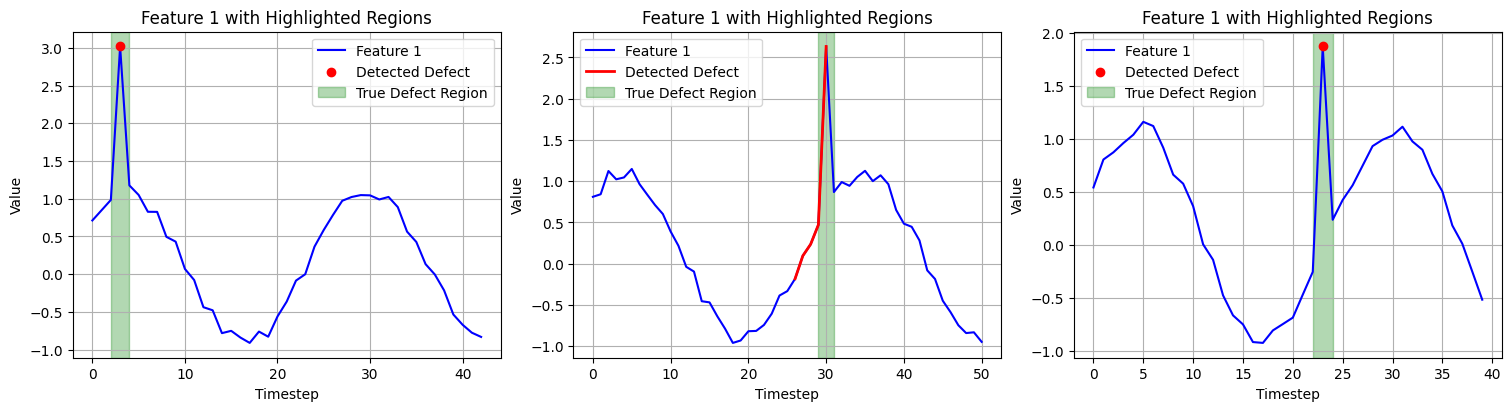

Class 1: Incorrect Predictions


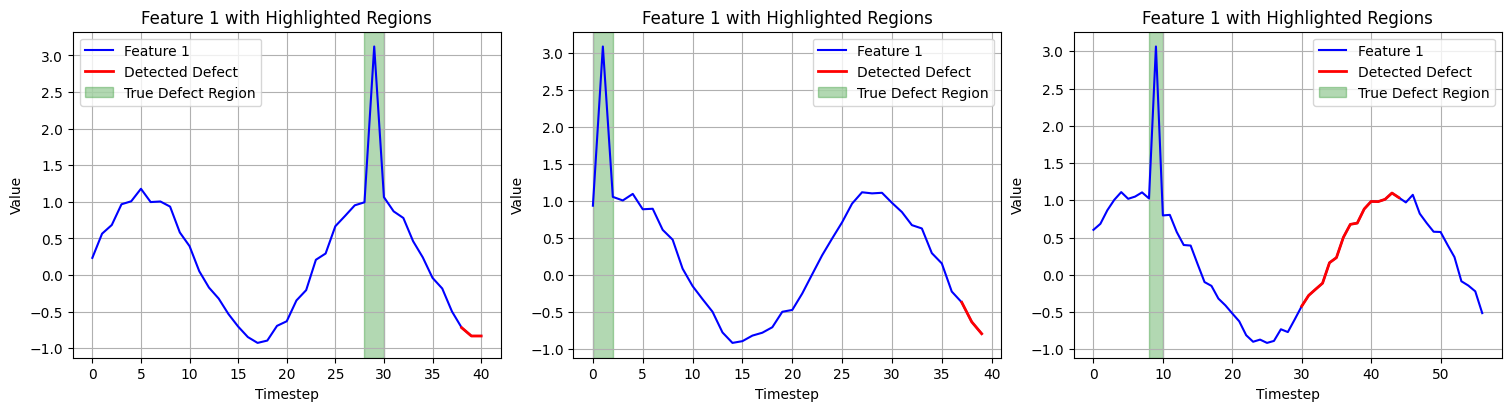

Class 2: Correct Predictions


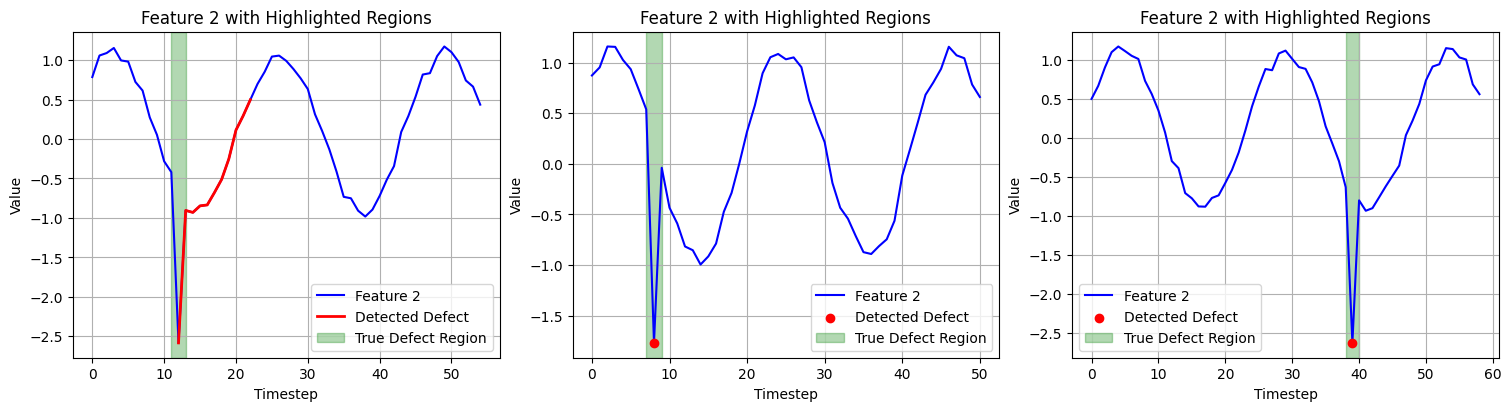

Class 2: Incorrect Predictions


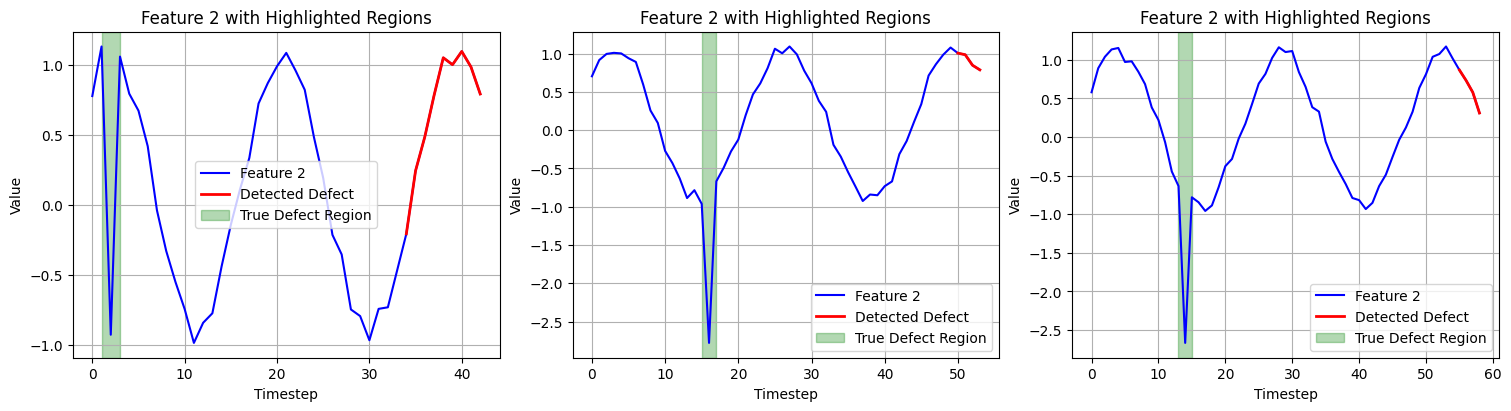

Class 3: Correct Predictions


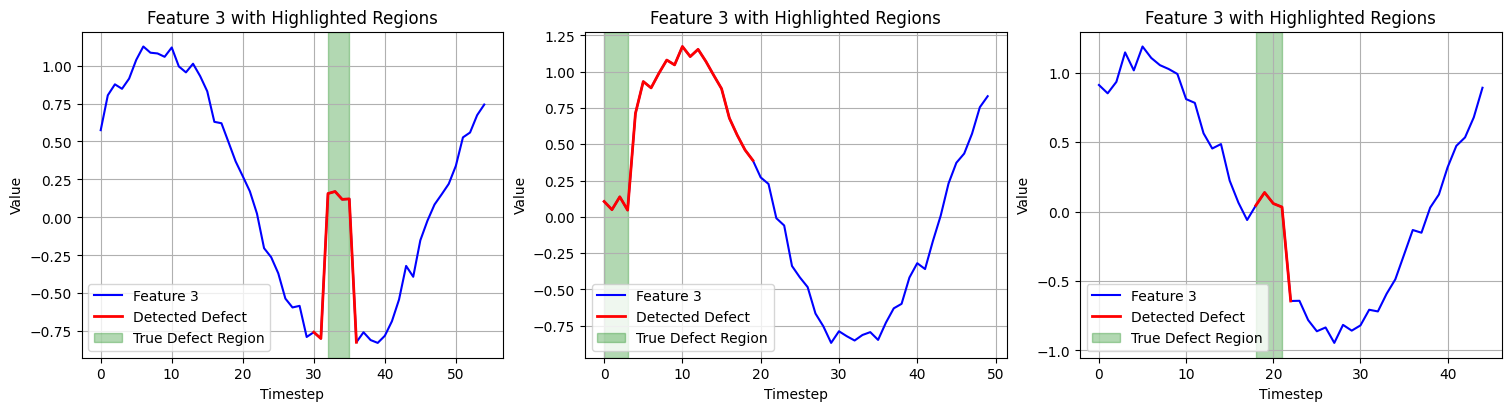

Class 3: Incorrect Predictions


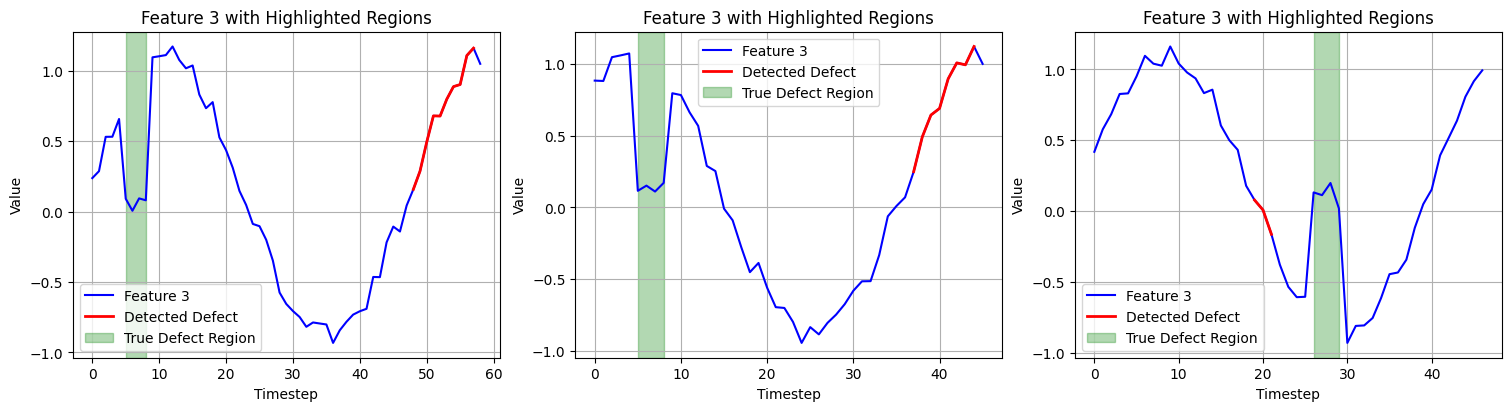

Class 4: Correct Predictions


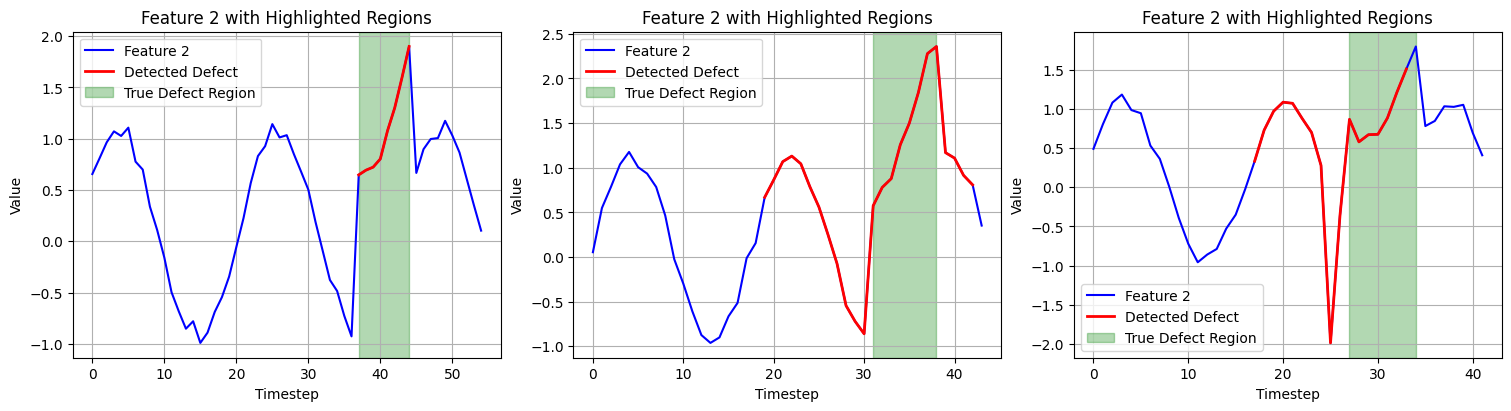

Class 4: Incorrect Predictions


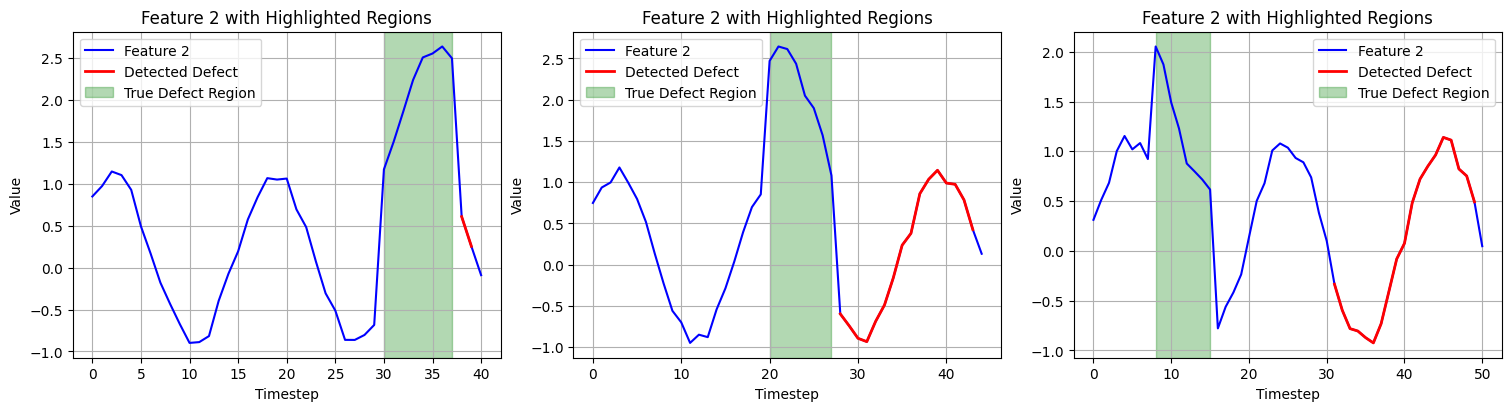

Class 5: Correct Predictions


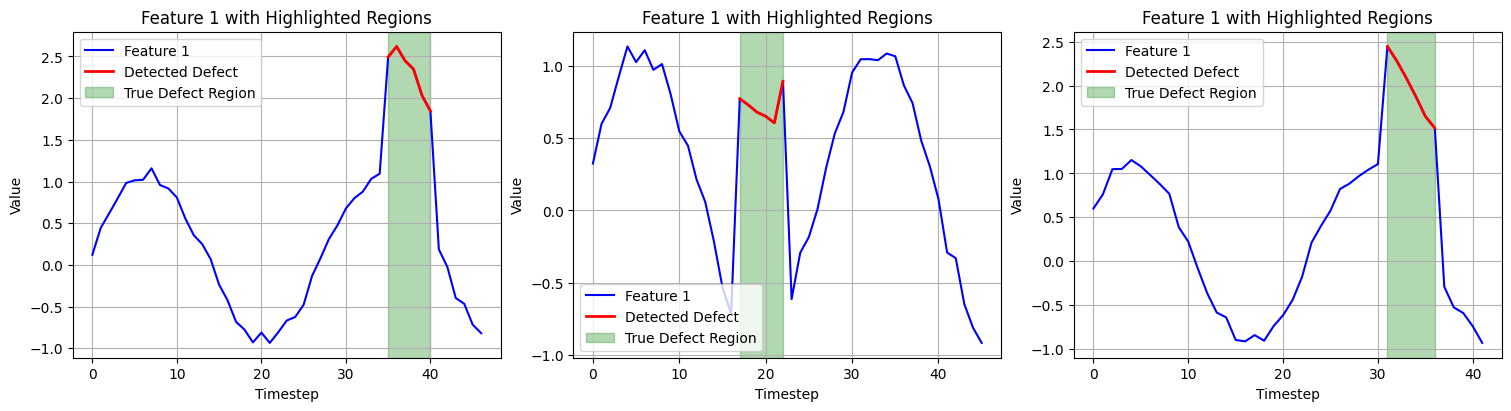

Class 5: Incorrect Predictions


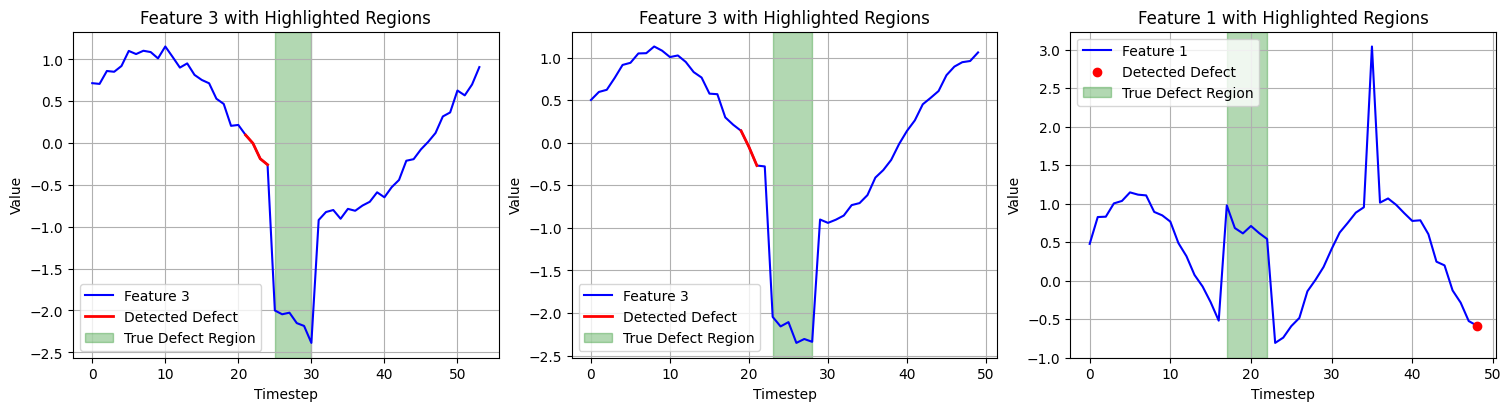

In [14]:
analyzer.analyze()

The plot below shows **defect-class feature mapping** (both predicted and expected). It shows how many times the defect of a given class was localized on a corresponding feature.

Plot on the right shows that defects of the first four classes occur only in a single feature and defects of class 5 are equally distributed between feature 1 and 3 (they are actually duplicated).

Plot on the left shows predictions of the model. The plot proves again that first two defect classes are easier to identify and they are only rarely mistaken with the 3rd feature. The class 4 in its turn has the most balanced numbers among features underlying struggles the model experiences with it. For the class 5 numbers are well destributed between the two correct features with predictions being skewed towards the first feature.

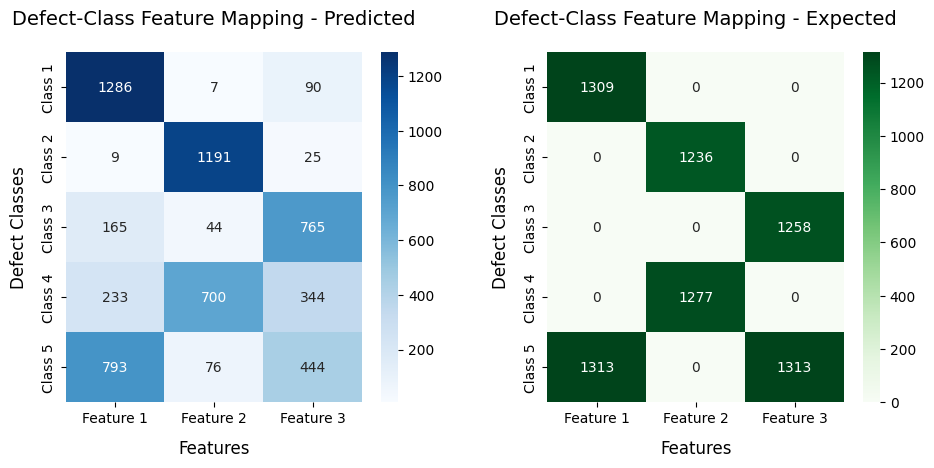

In [15]:
_ = analyzer.feature_class_matrix(plot=True)

The table below shows values of metrics for the model. Points made in the description of classes are correlated with this numbers.

In [16]:
pd.DataFrame(
    data=[["Accuracy", *class_based_accuracy, accuracy], ["IOU", *class_based_iou, iou]],
    columns=["Metric", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Overall"]
)

,Metric,Class 1,Class 2,Class 3,Class 4,Class 5,Overall
0,Accuracy,0.815562,0.880452,0.431711,0.067345,0.229627,0.443547
1,IOU,0.633020,0.636665,0.189518,0.022750,0.194866,0.337932


## Final remarks and future work

This project shows that even a simple model can work well for detecting and localizing defects in time-series data. The current approach achieves **44.35%** accuracy and **33.8%** IOU on the test set, which is a decent result. However, there are a lot of areas where the algorithm can be improved:

1. **Better understanding misclassifications**: Misclassifications need more analysis. For example, we should figure out why the model struggles with certain classes or why it sometimes highlights unrelated areas. This might show what patterns the model is incorrectly learning from.

2. **Improving Class 4 performance**: The model performs poorly on Class 4 defects, even compared to Class 3, which is also hard to detect. Finding out why this happens and adjusting the model or preprocessing for this class might help a lot.

3. **Testing new model designs**: Instead of just making layers bigger (e.g. 128 neurons vs 64), adding more layers to the model might improve how it extracts features.

4. **Revisiting preprocessing**: While normalization didn’t help much in initial tests, other preprocessing techniques might be worth trying. For example, improving how padding is handled or introducing more meaningful data augmentations could reduce noise in the training process.

5. **Handling multiple defect areas**: Right now, the model is limited to localize the defect on one feature at a time, but some classes (like Class 5) can affect multiple features at once. Updating the model to detect such situations could significantly improve accuracy.